In [1]:
import matplotlib.pyplot as plt
import numpy as np
import parameters 
import device 
import network
import numpy as np

/home/asude/.local/lib/python3.8/site-packages/samna
finished bindings


In [2]:
# open DYNAP-SE1 board to get Dynapse1Model
dynapse = device.DynapseDevice(sender_port=12321, receiver_port=12322)
model = dynapse.model

[0]:  Bus 3 Device 26 Dynapse1DevKit serial_number 00000027
[1]:  Bus 1 Device 21 Dynapse1DevKit serial_number 00000032
[2]:  Bus 1 Device 18 Dynapse1DevKit serial_number 00000000
[3]:  Bus 1 Device 20 Dynapse1DevKit serial_number 00000011
[4]:  Bus 1 Device 22 Dynapse1DevKit serial_number 00000007
[5]:  Bus 1 Device 2 Dynapse1DevKit serial_number 00000020
[6]:  Bus 1 Device 87 Dynapse1DevKit serial_number 00000033
Sender port: tcp://0.0.0.0:12321
Receiver port: tcp://0.0.0.0:12322
Opened device name: my_dynapse1
SamnaNode ID: 1
PythonNode ID: 2


In [20]:
neuron_ids = np.arange(1,2)
# duration = 1
# rate = 100 
# spike_times = np.linspace(0, duration, rate)
# spike_times = np.hstack((spike_times, 0*spike_times))
fpga_spikegen = dynapse.get_fpga_spikegen_rate(0, 0, 3, 100, 1)

# init a network generator
net = network.DynapseNetworkGenerator()
spikegens = net.get_spikegens(0, 0, 3)
neurons = net.get_neurons(0, 0, neuron_ids)

net.add_connections_one_to_one(spikegens, neurons, network.SYNAPSE_AMPA)

dynapse.monitor_neuron_network(neurons)
model.apply_configuration(net.get_config())

Checking if the given network is valid to be deployed on DYNAP-SE1 chips...
Validation complete: the network is good to go!
Converted the validated network to a Dynapse1 configuration!


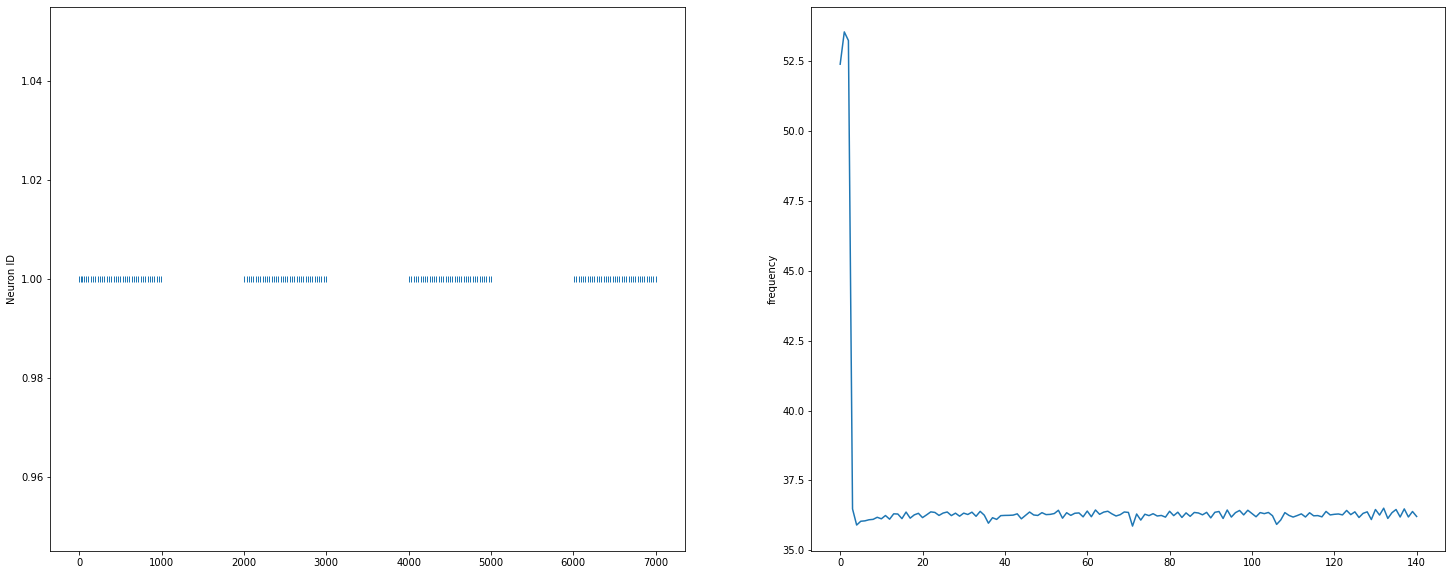

In [21]:
# # set params
# parameters.set_all_default_params(model)
# parameters.set_param(model, parameters.NEURON_DC_INPUT, (0,0), 0, 0)
# parameters.set_param(model, parameters.AMPA_WEIGHT, (7, 30), 0, 0)
# parameters.set_param(model, parameters.ADAPTATION_TIME_CONSTANT, (3,80), 0, 0)
# parameters.set_param(model, parameters.ADAPTATION_SOMETHING, (5,100), 0, 0)
# parameters.set_param(model, parameters.ADAPTATION_WEIGHT, (6,100), 0, 0)
# parameters.set_param(model, parameters.ADAPTATION_GAIN, (4,125), 0, 0)

# # set params
parameters.set_all_default_params(model)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (0,0), 0, 0)
parameters.set_param(model, parameters.AMPA_WEIGHT, (7, 30), 0, 0)
# parameters.set_param(model, parameters.ADAPTATION_TIME_CONSTANT, (0,0), 0, 0)
# parameters.set_param(model, parameters.ADAPTATION_SOMETHING, (0,0), 0, 0)
# parameters.set_param(model, parameters.ADAPTATION_WEIGHT, (0,0), 0, 0)
# parameters.set_param(model, parameters.ADAPTATION_GAIN, (0,0), 0, 0)

parameters.set_param(model, parameters.ADAPTATION_TIME_CONSTANT, (3,100), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_SOMETHING, (5,150), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_WEIGHT, (6,130), 0, 0)
parameters.set_param(model, parameters.ADAPTATION_GAIN, (4,125), 0, 0)


dynapse.start_graph()
dynapse.run_simulation(0.1) # bug with clearing the buffer at the moment - need to run the simulation for a little 
spikes = []
rates = []
for i in range (4):
	fpga_spikegen.start()
	these_spikes = dynapse.run_simulation(1)
	spikes_array = np.vstack(([spike.timestamp for spike in these_spikes],[spike.id for spike in these_spikes])).T
	rates = np.hstack((rates, 1e6/np.diff(spikes_array[:,0])))
	spikes += these_spikes
	fpga_spikegen.stop()
	these_spikes = dynapse.run_simulation(1)
	spikes_array = np.vstack(([spike.timestamp for spike in these_spikes],[spike.id for spike in these_spikes])).T
	rates = np.hstack((rates, 1e6/np.diff(spikes_array[:,0])))
	spikes += these_spikes
dynapse.stop_graph()

spikes_array = np.vstack(([spike.timestamp for spike in spikes],[spike.id for spike in spikes])).T
spikes_array[:,0] -= spikes_array[0,0]

# fig, axs = plt.subplots(1,2,figsize=(15,5), sharey=True)
# axs[0].plot(spikes_array[:,0]/1000, spikes_array[:,1], '|')
# axs[1].plot(rates, neuron_ids, '.')
# for i in range(len(vary)):	
# 	h_pos = (i*1 + 1)*1000
# 	axs[0].axvline(h_pos, neuron_ids[0]-1, neuron_ids[-1]+1, color = 'r', ls = ':')
# #axs[0].set_xlim([0, 1000])
# axs[0].set_xlim([8000, 10000])
# axs[1].set_ylim([neuron_ids[0]-1,neuron_ids[-1]+1])
# axs[0].set_ylabel('neuron ID')
# axs[1].set_xlabel('frequency')
# plt.show()
fig, axs = plt.subplots(1,2,figsize=(25,10))
axs[0].plot(spikes_array[:,0]/1000, spikes_array[:,1], '|')
axs[1].plot(rates)
axs[0].set_ylabel('Neuron ID')
axs[1].set_ylabel('frequency')
plt.show()

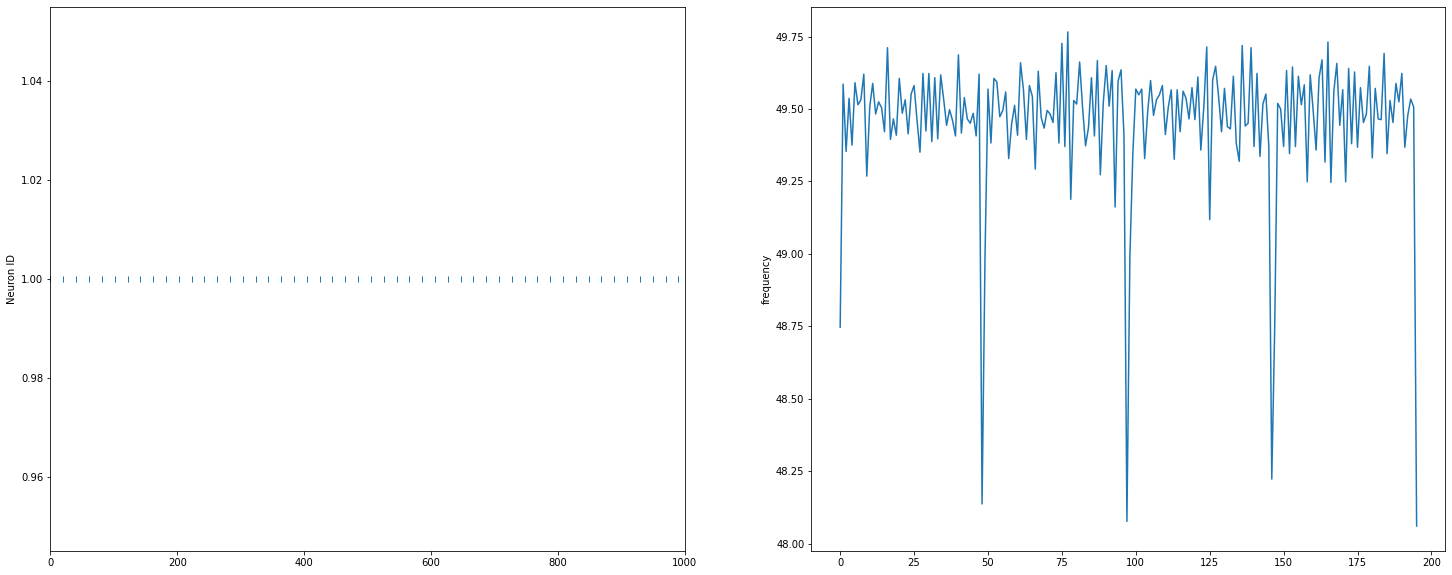

In [13]:
fig, axs = plt.subplots(1,2,figsize=(25,10))
axs[0].plot(spikes_array[:,0]/1000, spikes_array[:,1], '|')
axs[1].plot(rates)
axs[0].set_xlim([0,1000])
axs[0].set_ylabel('Neuron ID')
axs[1].set_ylabel('frequency')
plt.show()

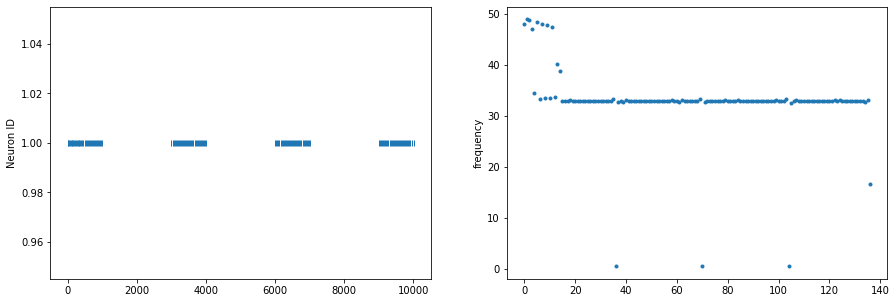

In [167]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(spikes_array[:,0]/1000, spikes_array[:,1], '|')
axs[1].plot(1e6/np.diff(spikes_array[:,0]),'.')
axs[0].set_ylabel('Neuron ID')
axs[1].set_ylabel('frequency')
plt.show()

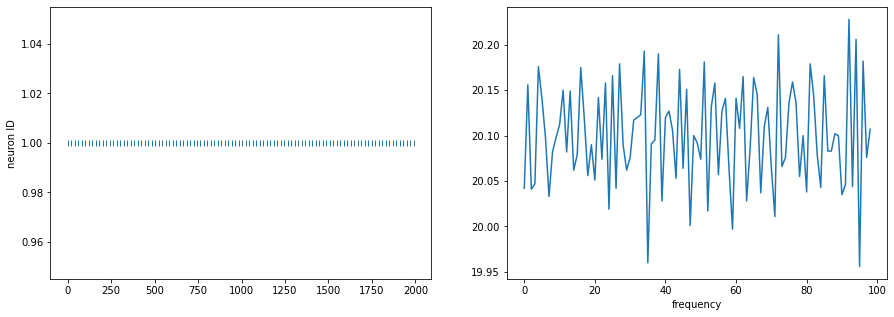

In [82]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(spikes_array[:,0]/1000, spikes_array[:,1], '|')
axs[1].plot(np.diff(spikes_array[:,0]/1000))
axs[0].set_ylabel('neuron ID')
axs[1].set_xlabel('frequency')
plt.show()

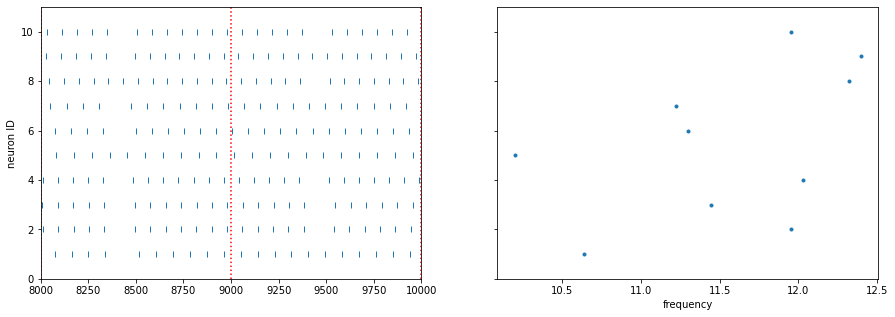

In [46]:
fig, axs = plt.subplots(1,2,figsize=(15,5), sharey=True)
axs[0].plot(spikes_array[:,0]/1000, spikes_array[:,1], '|')
axs[1].plot(rates, neuron_ids, '.')
for i in range(len(vary)):	
	h_pos = (i*1 + 1)*1000
	axs[0].axvline(h_pos, neuron_ids[0]-1, neuron_ids[-1]+1, color = 'r', ls = ':')
axs[0].set_xlim([8000, 10000])
axs[1].set_ylim([neuron_ids[0]-1,neuron_ids[-1]+1])
axs[0].set_ylabel('neuron ID')
axs[1].set_xlabel('frequency')
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(20,5), sharey=True)
axs[0].plot(spikes_array[:,0]/1000, spikes_array[:,1], '|')
axs[1].plot(rates, neuron_ids, '.')
for i in range(len(vary)):	
	h_pos = (i*0.5 + 0.5)*1000
	axs[0].axvline(h_pos, neuron_ids[0]-1, neuron_ids[-1]+1, color = 'r', ls = ':')
axs[1].set_ylim([neuron_ids[0]-1,neuron_ids[-1]+1])
axs[0].set_ylabel('neuron ID')
axs[1].set_xlabel('frequency')
plt.show()

In [ ]:
# Lower tau spikes more slowly, more adaptation = frequency of the spiking decreases more. 